# Stock Price Predictor

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [254]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data','AAPL-3.csv'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
df.head()

,Date,Open,High,Low,Close
0,1980-12-12,0.128348,0.128906,0.128348,0.128348
1,1980-12-15,0.122210,0.122210,0.121652,0.121652
2,1980-12-16,0.113281,0.113281,0.112723,0.112723
3,1980-12-17,0.115513,0.116071,0.115513,0.115513
4,1980-12-18,0.118862,0.119420,0.118862,0.118862


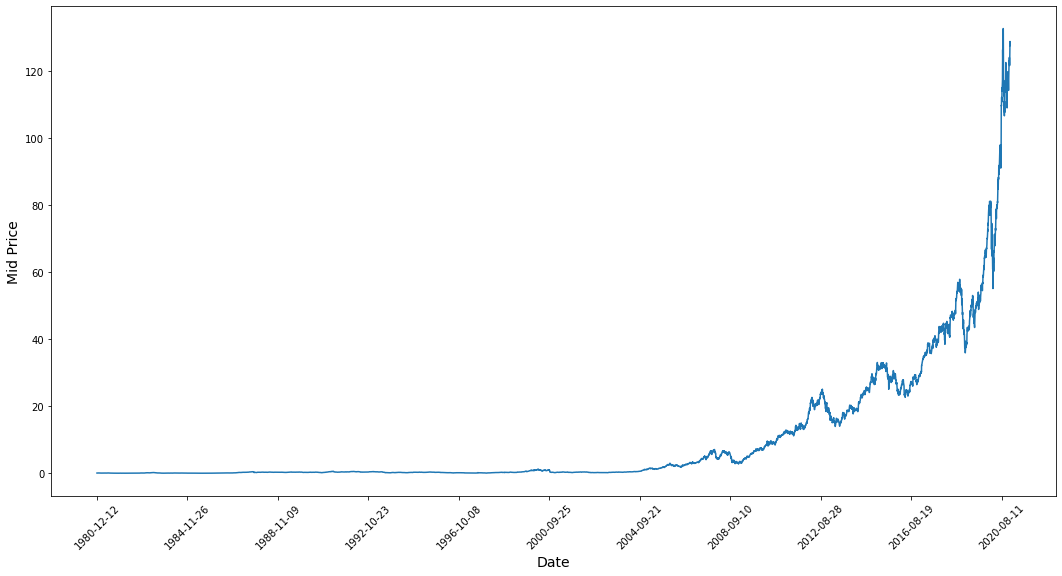

In [255]:
plt.figure(figsize=(18, 9))
sns.lineplot(range(df.shape[0]), (df['Low'] + df['High']) / 2.0)
plt.xticks(range(0, df.shape[0], 1000), df['Date'].loc[::1000], rotation=45)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Mid Price',fontsize=14)
plt.show()

In [256]:
# Getting a midtrpiaces in an array
high = np.array(list(df.loc[:, 'High']))
low = np.array(list(df.loc[:, 'Low']))
mid = (high + low) / 2
print(2 * len(mid) / 3)

6728.0


In [257]:
train_data = mid[:5576]
test_data = mid[5576:]

In [258]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
print(train_data.shape)
test_data = test_data.reshape(-1, 1)
print(test_data.shape)

(5576, 1)
(4516, 1)


In [259]:
# Skipped weird scaler stuff, will come back to this
# smoothing_window_size = 800
# for di in range(0, 8000,smoothing_window_size):
#     scaler.fit(train_data[di:di+smoothing_window_size,:])
#     train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# # You normalize the last bit of remaining data
# scaler.fit(train_data[di+smoothing_window_size:,:])
# train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [202]:
EMA = 0.0
gamma = 0.1
for t in range(5576):
    EMA = gamma * train_data[t] + (1 - gamma) * EMA
    train_data[t] = EMA

# Used for visualization and test purposes
all_mid = np.concatenate([train_data,test_data], axis=0)

In [203]:
window = 250
N = train_data.size
std_avg_pred = []
std_avg_x = []
mse_errors = []

for pred in range(window, N):
    if pred >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred, 'Date']
    
    # Add the training data for the date?
    std_avg_pred.append(np.mean(train_data[pred - window : pred]))
    # MSE adding
    mse_errors.append((std_avg_pred[-1] - train_data[pred])**2)
    # Add the dates
    std_avg_x.append(date)

print('MSE error for standard averaging: %.8f'%(0.5 * np.mean(mse_errors)))

MSE error for standard averaging: 0.26537449


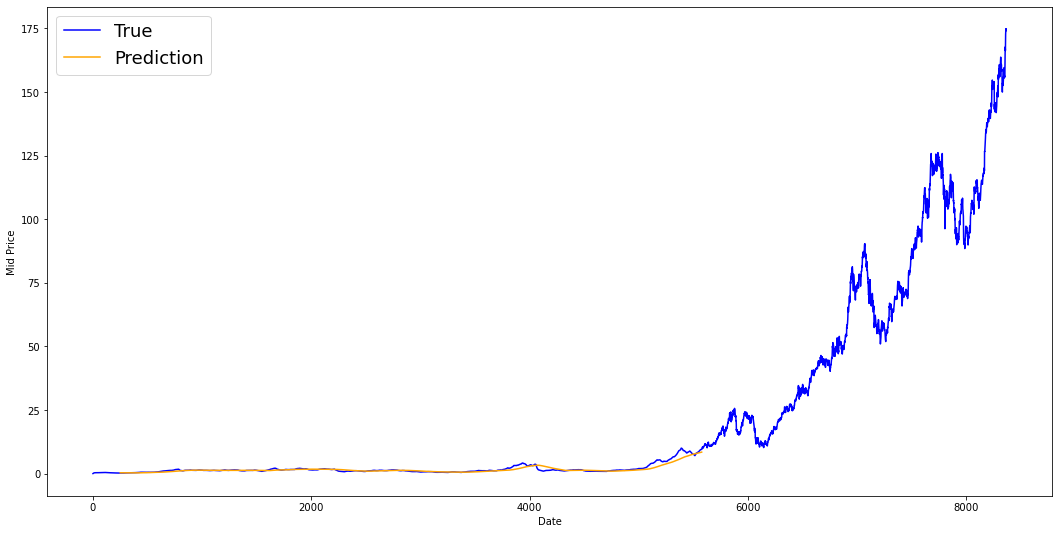

In [204]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), all_mid, color='b',label='True')
plt.plot(range(window, N),std_avg_pred, color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [260]:
data = df.sort_index(ascending=True, axis=0)
data.head()
print(len(data))

10092


In [276]:
#setting index
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [278]:
dataset = new_data.values
train = dataset[:8376]
test = dataset[8376:]
len(test)

1716

In [279]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

In [305]:
x_train = []
y_train = []
for i in range(60, len(train)):
    x_train.append(scaled[i - 60: i, 0])
    y_train.append(scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
# Create the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1)

6683/8316 [=======================>......] - ETA: 31s - loss: nan

In [281]:
inputs = new_data[len(new_data) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [300]:
x_test = []
for i in range(60, inputs.shape[0]):
    x_test.append(inputs[i - 60: i, 0])
x_test = np.array(x_test)
x_test.shape

(1716, 60)

In [301]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
closing_price = model.predict(x_test)
closing_price = scaler.inverse_transform(closing_price)

In [304]:
closing_price

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]])

In [303]:
train = new_data[:8376]
test = new_data[8376:]
test['Predictions'] = closing_price
test

<ipython-input-303-db91994f666c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = closing_price


,Close,Predictions
Date,,
2014-02-28,18.7943,NaN
2014-03-03,18.8486,NaN
2014-03-04,18.9729,NaN
2014-03-05,19.0129,NaN
2014-03-06,18.9554,NaN
...,...,...
2020-12-14,121.78,NaN
2020-12-15,127.88,NaN
2020-12-16,127.81,NaN


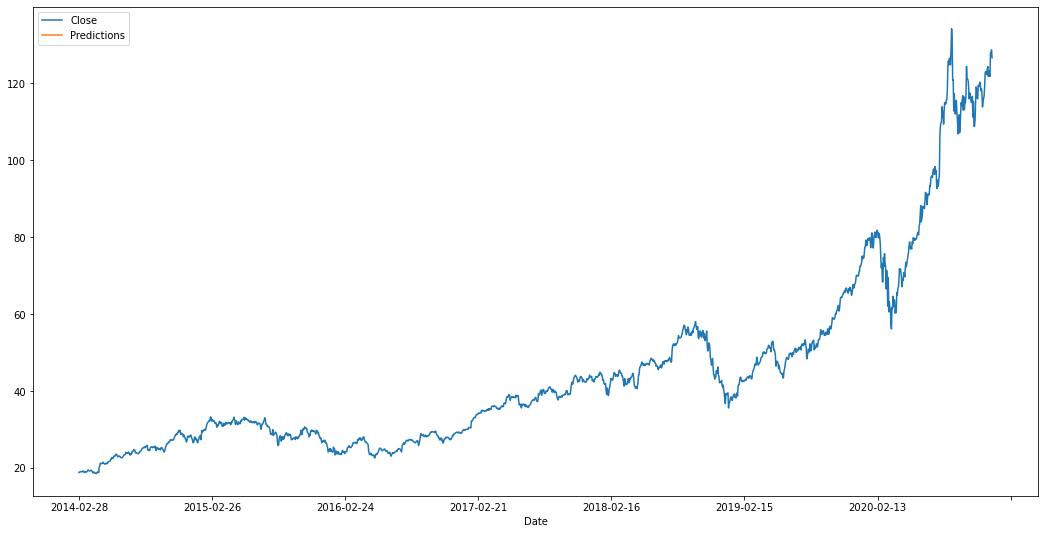

In [286]:
test.plot(figsize=(18, 9))

In [290]:
idx = pd.date_range('2017-11-11', periods=1200, freq='D')
forward = pd.Series(range(len(idx)), index=idx)
forward = pd.DataFrame(forward)
forward.drop(0, axis=1, inplace=True)

In [291]:
f_inputs = test.values
f_inputs = f_inputs.reshape(-1, 1)
f_inputs = scaler.transform(f_inputs)
print(f_inputs.shape)

(3432, 1)


In [292]:
f_test = []
for i in range(f_inputs.shape[0] - 1200, f_inputs.shape[0]):
    f_test.append(f_inputs[i - 100: i, 0])
f_test = np.array(f_test)
f_test.shape

(1200, 100)

In [293]:
f_test = np.reshape(f_test, (f_test.shape[0], f_test.shape[1], 1))
closing_price = model.predict(f_test)
closing_price = scaler.inverse_transform(closing_price)

In [294]:
forward["Apple Price Prediction"] = closing_price

In [295]:
apple_curr = pd.read_csv('AAPL-2.csv')

In [296]:
test1 = pd.DataFrame(forward["Apple Price Prediction"][:781])
apple_close = np.array(apple_curr['Close']).astype(float)
test1['Real Apple Price'] = apple_close
test1

,Apple Price Prediction,Real Apple Price
2017-11-11,NaN,43.492500
2017-11-12,NaN,42.834999
2017-11-13,NaN,42.270000
2017-11-14,NaN,42.775002
2017-11-15,NaN,42.537498
...,...,...
2019-12-27,NaN,121.779999
2019-12-28,NaN,127.879997
2019-12-29,NaN,127.809998
2019-12-30,NaN,128.699997


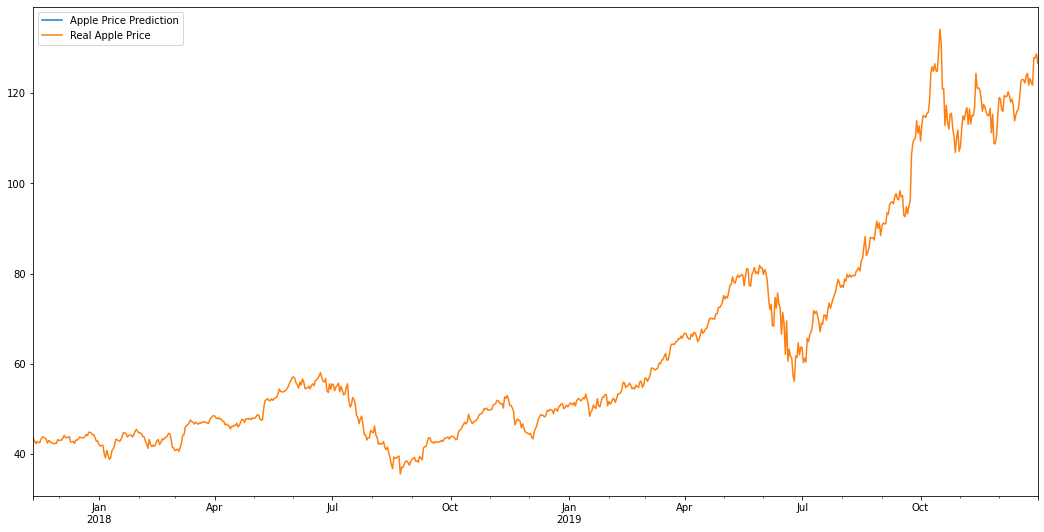

In [297]:
test1.plot(figsize=(18, 9))